## Combining Pat's RAMP simulator with noise generator 

Started April 20th <br>
Last edited April 21st

The RAMP simulator is per pixel now, should change to image by adding to noise generator (read noise, shot noise, 1/f (pink) noise) data cube and loop over reads. The noise generator takes longer for generating all the reads ...


In [9]:
from make_random_trace import make_random_trace
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt

import nghxrg as ng

In [7]:
# Instantiate a noise generator object for NIRSpec H2RGs. You
# can set verbose=True if you want to see diagnostic information. This
# will take about 20 seconds to execute on a modern laptop computer.
ng_h2rg = ng.HXRGNoise(verbose=False, naxis3 = 10)
#ng_h4rg = ng.HXRGNoise(naxis1=4096, naxis2=4096, n_out=32, nroh=8, verbose=False)


# Use parameters that generate noise similar to JWST NIRSpec
rd_noise=4.   # White read noise per integration
pedestal=4.   # DC pedestal drift rms
c_pink=3.     # Correlated pink noise
u_pink=1.     # Uncorrelated pink noise
acn=.5        # Correlated ACN
pca0_amp=.2   # Amplitude of PCA zero "picture frame" noise

# Do it
my_hdu = ng_h2rg.mknoise('ex_2.1.1.fits', rd_noise=rd_noise, pedestal=pedestal,
                c_pink=c_pink, u_pink=u_pink, acn=acn, pca0_amp=pca0_amp)

In [8]:
import astropy.io.fits as fits


# Open the result of Ex. 2.1.1
hdulist = fits.open('ex_2.1.1.fits')

# Add Poisson noise to the data
d = hdulist[0].data 

print(d.shape)

(10, 2048, 2048)


In [3]:
import astropy.io.fits as fits
# Setup
i_dark = 0.005# e-/s/pix
t = 934.# s

# Open the result of Ex. 2.1.1
hdulist = fits.open('ex_2.1.1.fits')

# Add Poisson noise to the data
d = hdulist[0].data + np.random.poisson(i_dark*t, np.shape(hdulist[0].data))

# Write result
hduout = fits.PrimaryHDU(d)
hduout.writeto('ex_2.1.1b.fits', clobber=True)

# Clean up
hdulist.close()

In [14]:
ng=15
nf=16
nd=11
darkcurrent = 0.04
lightcurrent = 10.0
nonlin = -5.0e-5
readnoise = 9. 
tf = 1.4548 # tf = 1.42 in DPU test Sec. 8.2.
detGain = 1.3 # detGain = 1/1.4 DPU test; typos "8.4"?
offsetADU = 0.

def sumRange(L,a,b,printslopes):                                                                                                                                                                                                
    s = 0                                                                                                                                                                                                         
    for i in range(a,b):  
        if printslopes:
            if i == a:
                print('Group slopes:')
            print(i, ' ', L[i] - L[i-1])
        s += pow((L[i] - L[i-1]) + beta,2)  
    return s 

Slope DPU =  238.77384942980896
Signal DPU =  3342.8338920173255
Quality Flag =  127.27428017261576
Slope Polyfit(1) =  166.8332591072698  Chi-Squared =  2112.6478037844176


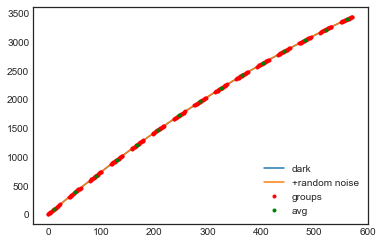

In [15]:
sigmaRead = readnoise/detGain # ADU
fluence = ( darkcurrent + lightcurrent )/ detGain  # ADU/sec
tgrp = (nf + nd)*tf
tint = (ng-1.)*(nf+nd)*tf

nreads = int((ng*nf + (ng-1.)*nd))
texp =  nreads*tf

# time vector
read = np.arange(nreads)
tread = read*tf
fdark = fluence*tread + nonlin*((fluence*tread)**2) #  curved signal
plt.plot(tread,fdark,label='dark')

rg = np.random.rand(nreads)            
fdarkN = fdark + rg * sigmaRead  / np.max(rg)  

plt.plot(tread,fdarkN,label='+random noise')



alpha = (1 - (nf**2))/(3.*nf*(nf+nd))  
beta = 2.*(sigmaRead**2)/(nf*(alpha+1))   

s2 = np.float()
t2 = np.float()
for i in range(nreads):
    if i % int(nf+nd) in (range(nf)):
        s = fdarkN[i]
        t = tread[i]
        s2 = np.append(s2, s)
        t2 = np.append(t2, t) 

plt.plot(t2,s2,'r.',label='groups')

fgrp = np.reshape(s2[1:],[ng,nf])
tgrp = np.reshape(t2[1:],[ng,nf])
fgrpavg,tgrpavg =[],[]
for i in range(ng):
    fga = np.mean(fgrp[i,:])
    tga = np.mean(tgrp[i,:])
    fgrpavg = np.append(fgrpavg, fga)
    tgrpavg = np.append(tgrpavg, tga)

#fgrpavg = fgrpavg[1:]
#tgrpavg = tgrpavg[1:]
plt.plot(tgrpavg,fgrpavg,'g.',label='avg')


L = fgrpavg   
deltaT = tgrpavg[1]-tgrpavg[0] 
a = 1
b = ng

slopeDPU_1 = np.sqrt( 1 + 4 * ( sumRange(L,a,b,0)/((ng - 1)*((1+alpha)**2)) ) )  # DPU Manual
slopeDPU_0 = (1 + alpha) / 2.  # DPU manual
slopeDPU = slopeDPU_0 * (slopeDPU_1 - 1) - beta
print('Slope DPU = ', slopeDPU)

signalDPU = slopeDPU * (ng - 1) + offsetADU # Downlinked signal in ADU
print('Signal DPU = ', signalDPU)


pseudoFlux = np.sqrt ( sumRange(L,a,b,0) / (ng - 1) ) - beta
QF = ( 2*detGain/(1+alpha) ) * ( (ng - 1)*pseudoFlux - (fgrpavg[ng-1] - fgrpavg[0]) )
print('Quality Flag = ', QF) 

    # Simple least squares fit to the full ramp for comparison
coeff = poly.polyfit(tread[1:], fdarkN[1:], 1)
ffit = poly.polyval(tread[1:], coeff)
chisqr = np.sum((poly.polyval(tread, coeff) - fdarkN) ** 2) / np.std(fdarkN)

print("Slope Polyfit(1) = ", coeff[0]," Chi-Squared = ", chisqr)

plt.legend(loc=4)
